# 01. Setup y Carga de Datos M5

---

**Fase 1** - Setup y Exploración de Datos

**Objetivo:** Cargar y explorar los datos M5 de Kaggle, comprender su estructura y preparar el dataset base para análisis de forecasting de urgencias.

**Input:** 
- `data/raw/sales_train_evaluation.csv` (ventas diarias por producto)
- `data/raw/calendar.csv` (mapeo de días a fechas)
- `data/raw/sell_prices.csv` (precios por tienda y fecha)

**Output:**
- `data/processed/sales_daily.csv` (ventas en formato largo)
- `data/processed/sales_weekly.csv` (ventas agregadas semanalmente)

---

## 1. Configuración Inicial

In [2]:
# Imports estándar
# %pip install matplotlib
# %pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime

# Configuración
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
np.random.seed(42)

# Estilo de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')

print("✓ Librerías cargadas correctamente")
print(f"  - Pandas version: {pd.__version__}")
print(f"  - NumPy version: {np.__version__}")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.
✓ Librerías cargadas correctamente
  - Pandas version: 2.3.2
  - NumPy version: 2.3.3



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Configuración de paths
PROJECT_ROOT = Path.cwd().parent
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
FIGURES = PROJECT_ROOT / 'results' / 'figures'

# Crear carpetas si no existen
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
FIGURES.mkdir(parents=True, exist_ok=True)

# Constantes del proyecto
RANDOM_SEED = 42
FIGSIZE_STANDARD = (12, 6)
FIGSIZE_WIDE = (15, 5)

print(f"✓ Paths configurados:")
print(f"  - DATA_RAW: {DATA_RAW}")
print(f"  - DATA_PROCESSED: {DATA_PROCESSED}")
print(f"  - FIGURES: {FIGURES}")

✓ Paths configurados:
  - DATA_RAW: c:\Users\yelko\Documents\GitHub\Portfolio\04-forecasting-demanda-urgente-manufactura\data\raw
  - DATA_PROCESSED: c:\Users\yelko\Documents\GitHub\Portfolio\04-forecasting-demanda-urgente-manufactura\data\processed
  - FIGURES: c:\Users\yelko\Documents\GitHub\Portfolio\04-forecasting-demanda-urgente-manufactura\results\figures


## 2. Carga de Datos M5

### Contexto del Dataset M5

El dataset M5 (Makridakis-5) de Kaggle contiene datos de ventas de Walmart con:
- **30,490 productos** jerárquicamente organizados
- **10 tiendas** en 3 estados (CA, TX, WI)
- **1,941 días** de ventas históricas
- Variables: precios, eventos, SNAP (programa asistencia alimentaria)

**Estructura:**
- Ventas en formato ancho: cada columna `d_1`, `d_2`, ..., `d_1941` es un día
- Calendar: mapea días a fechas reales, eventos, días de semana
- Prices: precios semanales por producto y tienda

In [7]:
# Cargar calendar (ligero, carga rápida)
print("Cargando calendar.csv...")
calendar = pd.read_csv(DATA_RAW / 'calendar.csv')
print(f"✓ Calendar cargado: {calendar.shape}")
print(f"  - Rango de fechas: {calendar['date'].min()} a {calendar['date'].max()}")
print()

# Mostrar primeras filas
print("Primeras filas de calendar:")
calendar.head()

Cargando calendar.csv...
✓ Calendar cargado: (1969, 14)
  - Rango de fechas: 2011-01-29 a 2016-06-19

Primeras filas de calendar:


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [8]:
# Información del calendar
print("Información de calendar:")
print("="*60)
calendar.info()
print()
print("Valores únicos por columna:")
for col in calendar.columns:
    print(f"  - {col}: {calendar[col].nunique()} valores únicos")

Información de calendar:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB

Valores únicos por columna:
  - date: 1969 valores únicos
  - wm_yr_wk: 282 valores únicos
  - weekday: 7 valores únicos
  - wday: 7 valores ún

### Cargar Ventas (Evaluation)

**Nota:** Este archivo es grande (~60MB), la carga puede tardar 10-20 segundos.

In [9]:
# Cargar sales (más pesado)
print("Cargando sales_train_evaluation.csv...")
print("(Puede tardar 10-20 segundos)")

sales = pd.read_csv(DATA_RAW / 'sales_train_evaluation.csv')

print(f"✓ Sales cargado: {sales.shape}")
print(f"  - Productos: {sales.shape[0]:,}")
print(f"  - Columnas (identif. + días): {sales.shape[1]}")
print(f"  - Días de ventas: {sales.shape[1] - 6}")
print(f"  - Memoria: {sales.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print()

# Mostrar estructura
print("Primeras columnas (identificadores):")
sales.iloc[:5, :10]

Cargando sales_train_evaluation.csv...
(Puede tardar 10-20 segundos)
✓ Sales cargado: (30490, 1947)
  - Productos: 30,490
  - Columnas (identif. + días): 1947
  - Días de ventas: 1941
  - Memoria: 461.90 MB

Primeras columnas (identificadores):


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0


In [10]:
# Información del dataset de ventas
print("Información de sales:")
print("="*60)
sales.info(verbose=False)
print()

# Columnas identificadoras
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
print(f"Columnas identificadoras: {id_cols}")
print(f"Columnas de ventas diarias: d_1 a d_{sales.shape[1] - len(id_cols)}")
print()

# Distribución por categorías
print("Distribución de productos:")
print(f"  - Estados: {sales['state_id'].nunique()} ({sales['state_id'].unique()})")
print(f"  - Tiendas: {sales['store_id'].nunique()}")
print(f"  - Categorías: {sales['cat_id'].nunique()} ({sales['cat_id'].unique()})")
print(f"  - Departamentos: {sales['dept_id'].nunique()}")
print(f"  - Items únicos: {sales['item_id'].nunique()}")

Información de sales:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB

Columnas identificadoras: ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
Columnas de ventas diarias: d_1 a d_1941

Distribución de productos:
  - Estados: 3 (['CA' 'TX' 'WI'])
  - Tiendas: 10
  - Categorías: 3 (['HOBBIES' 'HOUSEHOLD' 'FOODS'])
  - Departamentos: 7
  - Items únicos: 3049


In [11]:
# Cargar precios
print("Cargando sell_prices.csv...")
prices = pd.read_csv(DATA_RAW / 'sell_prices.csv')

print(f"✓ Prices cargado: {prices.shape}")
print(f"  - Registros de precios: {prices.shape[0]:,}")
print()

print("Primeras filas de prices:")
prices.head()

Cargando sell_prices.csv...
✓ Prices cargado: (6841121, 4)
  - Registros de precios: 6,841,121

Primeras filas de prices:


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


## 3. Análisis Exploratorio de Datos (EDA)

### 3.1 Estadísticas Descriptivas de Ventas

In [12]:
# Extraer solo columnas de días
day_cols = [col for col in sales.columns if col.startswith('d_')]
print(f"Analizando {len(day_cols)} días de ventas...")
print()

# Estadísticas por día (promedio de ventas por producto)
daily_sales = sales[day_cols]

print("Estadísticas descriptivas de ventas diarias:")
print("="*60)
stats = daily_sales.describe().T
stats['sum'] = daily_sales.sum()
print(stats.head(20))
print("...")
print(stats.tail(20))

Analizando 1941 días de ventas...

Estadísticas descriptivas de ventas diarias:
        count      mean       std  min  25%  50%  75%    max    sum
d_1   30490.0  1.070220  5.126689  0.0  0.0  0.0  0.0  360.0  32631
d_2   30490.0  1.041292  5.365468  0.0  0.0  0.0  0.0  436.0  31749
d_3   30490.0  0.780026  3.667454  0.0  0.0  0.0  0.0  207.0  23783
d_4   30490.0  0.833454  4.415141  0.0  0.0  0.0  0.0  323.0  25412
d_5   30490.0  0.627944  3.379344  0.0  0.0  0.0  0.0  296.0  19146
d_6   30490.0  0.958052  4.785947  0.0  0.0  0.0  0.0  314.0  29211
d_7   30490.0  0.918662  5.059495  0.0  0.0  0.0  0.0  316.0  28010
d_8   30490.0  1.244080  6.617729  0.0  0.0  0.0  0.0  370.0  37932
d_9   30490.0  1.073663  5.917204  0.0  0.0  0.0  0.0  385.0  32736
d_10  30490.0  0.838701  4.206199  0.0  0.0  0.0  0.0  353.0  25572
d_11  30490.0  0.756674  3.665969  0.0  0.0  0.0  0.0  279.0  23071
d_12  30490.0  0.775927  3.697822  0.0  0.0  0.0  0.0  258.0  23658
d_13  30490.0  0.779141  3.486595  0

In [13]:
# Análisis de ventas totales por día
total_sales_per_day = daily_sales.sum(axis=0)

print("Ventas totales agregadas:")
print("="*60)
print(f"  - Total de unidades vendidas (todos los días): {total_sales_per_day.sum():,.0f}")
print(f"  - Promedio diario: {total_sales_per_day.mean():,.0f} unidades")
print(f"  - Día con más ventas: {total_sales_per_day.idxmax()} ({total_sales_per_day.max():,.0f} unidades)")
print(f"  - Día con menos ventas: {total_sales_per_day.idxmin()} ({total_sales_per_day.min():,.0f} unidades)")
print()

# Estadísticas por producto
total_sales_per_product = daily_sales.sum(axis=1)
print("Ventas por producto:")
print("="*60)
print(f"  - Promedio de ventas por producto: {total_sales_per_product.mean():,.0f} unidades")
print(f"  - Mediana: {total_sales_per_product.median():,.0f} unidades")
print(f"  - Producto con más ventas: {total_sales_per_product.max():,.0f} unidades")
print(f"  - Producto con menos ventas: {total_sales_per_product.min():,.0f} unidades")
print(f"  - Productos con 0 ventas: {(total_sales_per_product == 0).sum()}")

Ventas totales agregadas:
  - Total de unidades vendidas (todos los días): 66,927,173
  - Promedio diario: 34,481 unidades
  - Día con más ventas: d_1934 (59,921 unidades)
  - Día con menos ventas: d_697 (11 unidades)

Ventas por producto:
  - Promedio de ventas por producto: 2,195 unidades
  - Mediana: 868 unidades
  - Producto con más ventas: 253,859 unidades
  - Producto con menos ventas: 15 unidades
  - Productos con 0 ventas: 0


### 3.2 Visualización de Series Temporales

In [14]:
# Crear serie temporal de ventas totales diarias con fechas reales
# Mapear días a fechas usando calendar
calendar['date'] = pd.to_datetime(calendar['date'])
day_to_date = dict(zip(calendar['d'], calendar['date']))

# Convertir ventas a serie temporal
ts_sales = pd.Series(
    total_sales_per_day.values,
    index=[day_to_date[d] for d in day_cols]
)
ts_sales = ts_sales.sort_index()

print(f"Serie temporal creada: {len(ts_sales)} días")
print(f"Rango: {ts_sales.index.min()} a {ts_sales.index.max()}")

Serie temporal creada: 1941 días
Rango: 2011-01-29 00:00:00 a 2016-05-22 00:00:00


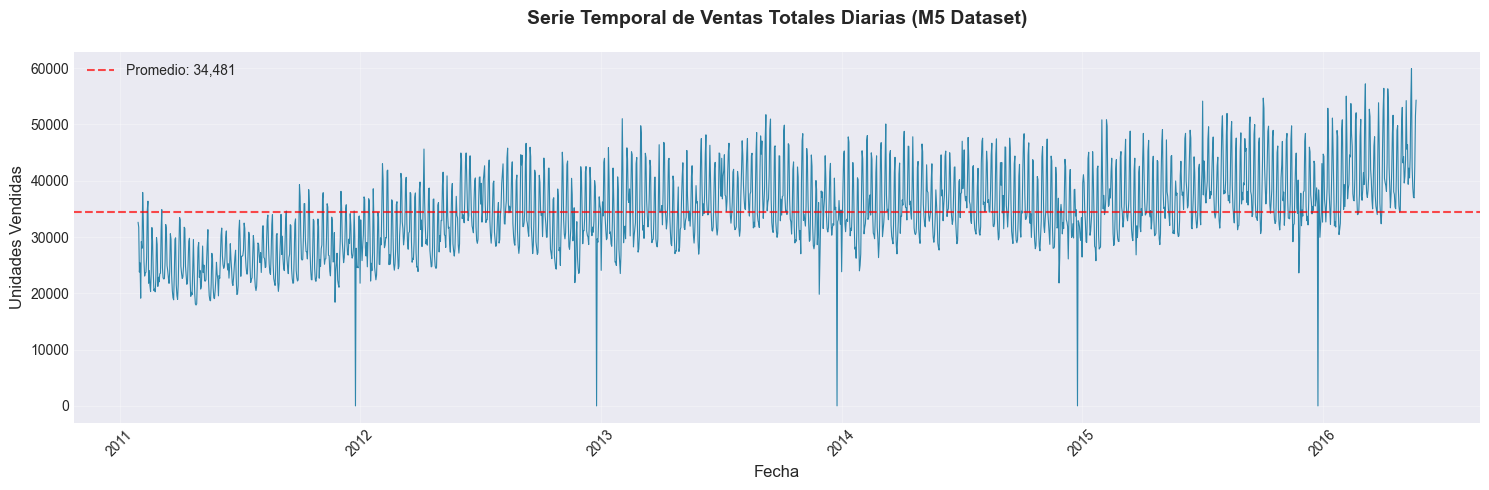

✓ Gráfico guardado en: results/figures/01_serie_temporal_ventas_diarias.png


In [15]:
# Gráfico de serie temporal completa
fig, ax = plt.subplots(figsize=FIGSIZE_WIDE)

ax.plot(ts_sales.index, ts_sales.values, linewidth=0.8, color='#2E86AB')
ax.set_title('Serie Temporal de Ventas Totales Diarias (M5 Dataset)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Unidades Vendidas', fontsize=12)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# Añadir línea de promedio
ax.axhline(ts_sales.mean(), color='red', linestyle='--', 
           linewidth=1.5, alpha=0.7, label=f'Promedio: {ts_sales.mean():,.0f}')
ax.legend()

plt.tight_layout()
plt.savefig(FIGURES / '01_serie_temporal_ventas_diarias.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado en: results/figures/01_serie_temporal_ventas_diarias.png")

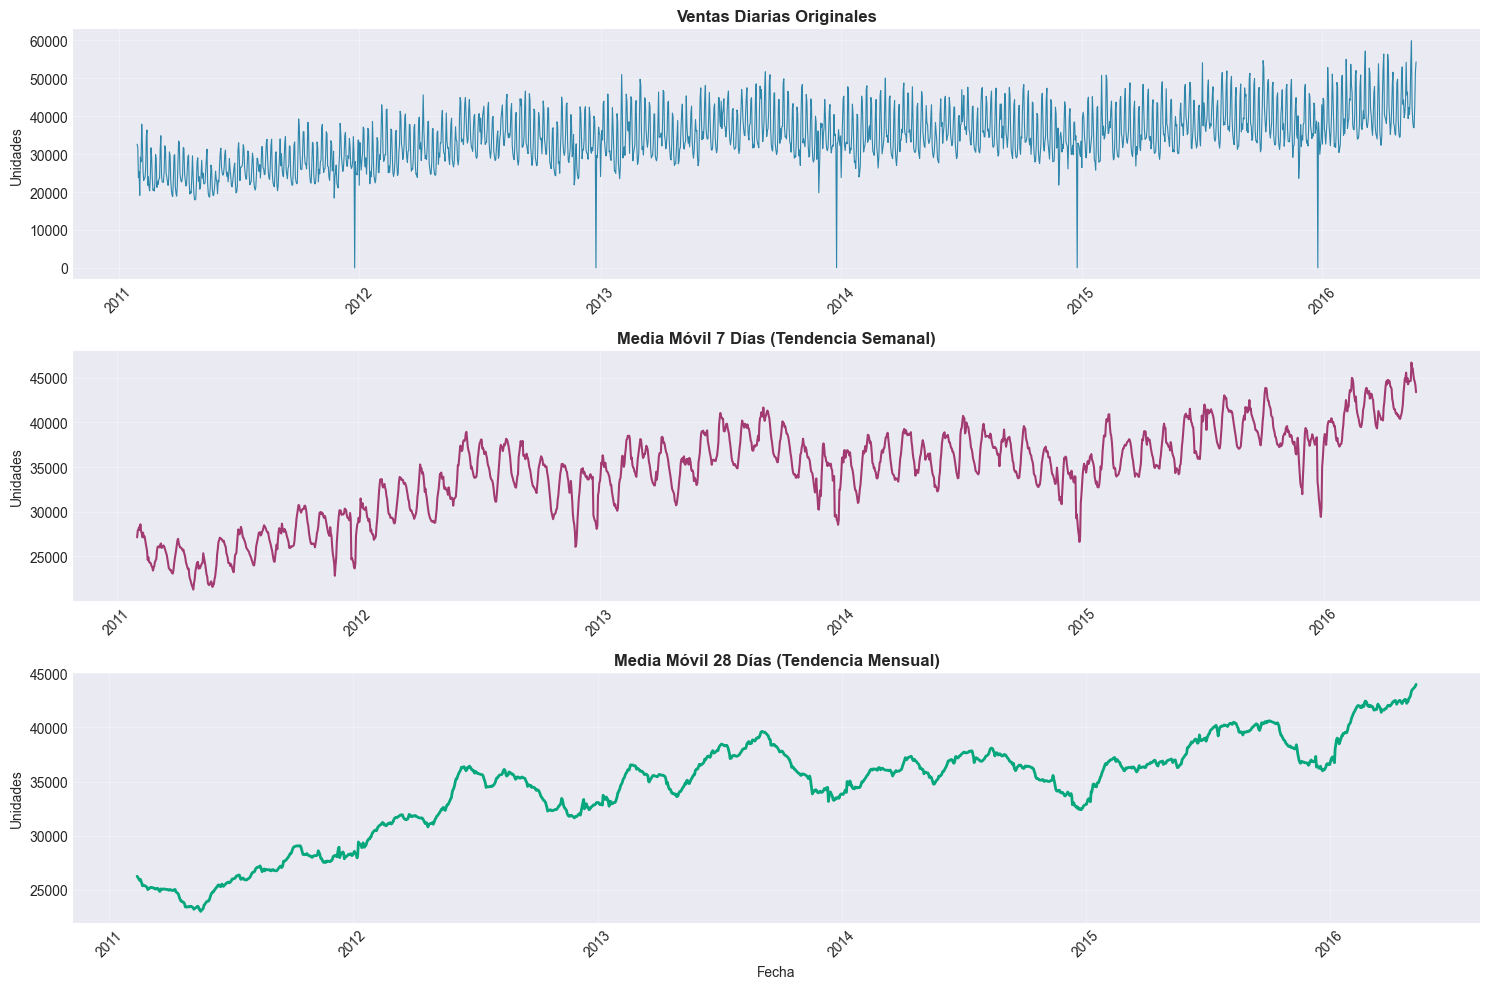

✓ Gráfico guardado en: results/figures/01_analisis_tendencia_estacionalidad.png


In [16]:
# Análisis de tendencia y estacionalidad visual
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# 1. Serie original
axes[0].plot(ts_sales.index, ts_sales.values, linewidth=0.8, color='#2E86AB')
axes[0].set_title('Ventas Diarias Originales', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Unidades')
axes[0].grid(True, alpha=0.3)

# 2. Media móvil 7 días (semanal)
ma7 = ts_sales.rolling(window=7, center=True).mean()
axes[1].plot(ts_sales.index, ma7.values, linewidth=1.5, color='#A23B72')
axes[1].set_title('Media Móvil 7 Días (Tendencia Semanal)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Unidades')
axes[1].grid(True, alpha=0.3)

# 3. Media móvil 28 días (mensual)
ma28 = ts_sales.rolling(window=28, center=True).mean()
axes[2].plot(ts_sales.index, ma28.values, linewidth=2, color='#06A77D')
axes[2].set_title('Media Móvil 28 Días (Tendencia Mensual)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('Unidades')
axes[2].grid(True, alpha=0.3)

for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(FIGURES / '01_analisis_tendencia_estacionalidad.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado en: results/figures/01_analisis_tendencia_estacionalidad.png")

### 3.3 Análisis de Distribución de Ventas

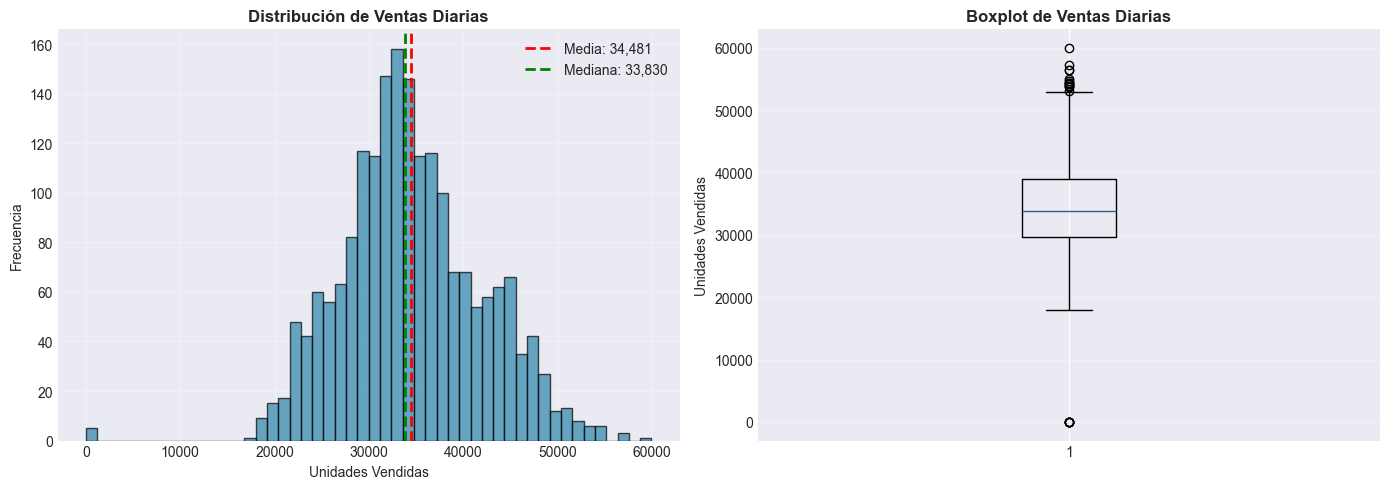

✓ Gráfico guardado en: results/figures/01_distribucion_ventas.png


In [17]:
# Distribución de ventas diarias (agregadas)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(ts_sales.values, bins=50, color='#2E86AB', alpha=0.7, edgecolor='black')
axes[0].axvline(ts_sales.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Media: {ts_sales.mean():,.0f}')
axes[0].axvline(ts_sales.median(), color='green', linestyle='--', 
                linewidth=2, label=f'Mediana: {ts_sales.median():,.0f}')
axes[0].set_title('Distribución de Ventas Diarias', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Unidades Vendidas')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
axes[1].boxplot(ts_sales.values, vert=True)
axes[1].set_title('Boxplot de Ventas Diarias', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Unidades Vendidas')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES / '01_distribucion_ventas.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado en: results/figures/01_distribucion_ventas.png")

In [18]:
# Análisis de valores atípicos
Q1 = ts_sales.quantile(0.25)
Q3 = ts_sales.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_low = ts_sales[ts_sales < lower_bound]
outliers_high = ts_sales[ts_sales > upper_bound]

print("Análisis de Outliers:")
print("="*60)
print(f"  - Q1 (25%): {Q1:,.0f}")
print(f"  - Q3 (75%): {Q3:,.0f}")
print(f"  - IQR: {IQR:,.0f}")
print(f"  - Límite inferior: {lower_bound:,.0f}")
print(f"  - Límite superior: {upper_bound:,.0f}")
print()
print(f"  - Outliers bajos: {len(outliers_low)} días ({len(outliers_low)/len(ts_sales)*100:.2f}%)")
print(f"  - Outliers altos: {len(outliers_high)} días ({len(outliers_high)/len(ts_sales)*100:.2f}%)")
print()

if len(outliers_high) > 0:
    print("Top 5 días con ventas más altas (posibles urgencias):")
    top5 = ts_sales.nlargest(5)
    for date, value in top5.items():
        print(f"  - {date.strftime('%Y-%m-%d')}: {value:,.0f} unidades")

Análisis de Outliers:
  - Q1 (25%): 29,713
  - Q3 (75%): 39,008
  - IQR: 9,295
  - Límite inferior: 15,770
  - Límite superior: 52,950

  - Outliers bajos: 5 días (0.26%)
  - Outliers altos: 14 días (0.72%)

Top 5 días con ventas más altas (posibles urgencias):
  - 2016-05-15: 59,921 unidades
  - 2016-03-06: 57,218 unidades
  - 2016-04-03: 56,425 unidades
  - 2016-04-09: 56,340 unidades
  - 2016-02-06: 55,040 unidades


## 4. Transformación de Datos

### 4.1 Convertir de Formato Ancho a Largo

**Formato actual:** Cada producto es una fila, cada día es una columna  
**Formato objetivo:** Una fila por (producto, día) con columnas: id, fecha, ventas, precio, etc.

In [19]:
print("Transformando datos de formato ancho a largo...")
print("(Esta operación puede tardar 30-60 segundos)")
print()

# Melt: convertir columnas d_1, d_2, ... a filas
sales_long = sales.melt(
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    var_name='d',
    value_name='sales'
)

print(f"✓ Transformación completada")
print(f"  - Forma original: {sales.shape}")
print(f"  - Forma long: {sales_long.shape}")
print(f"  - Filas creadas: {sales_long.shape[0]:,}")
print()

print("Primeras filas del formato largo:")
sales_long.head(10)

Transformando datos de formato ancho a largo...
(Esta operación puede tardar 30-60 segundos)

✓ Transformación completada
  - Forma original: (30490, 1947)
  - Forma long: (59181090, 8)
  - Filas creadas: 59,181,090

Primeras filas del formato largo:


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
5,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
6,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
7,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12
8,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2
9,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [20]:
# Merge con calendar para obtener fechas reales
print("Agregando información temporal desde calendar...")

sales_long = sales_long.merge(
    calendar[['d', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year']],
    on='d',
    how='left'
)

# Convertir date a datetime
sales_long['date'] = pd.to_datetime(sales_long['date'])

print(f"✓ Merge completado: {sales_long.shape}")
print()
print("Dataset con fechas:")
sales_long.head(10)

Agregando información temporal desde calendar...
✓ Merge completado: (59181090, 14)

Dataset con fechas:


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011
5,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011
6,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011
7,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12,2011-01-29,11101,Saturday,1,1,2011
8,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2,2011-01-29,11101,Saturday,1,1,2011
9,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011


In [21]:
# Merge con precios
print("Agregando información de precios...")

sales_long = sales_long.merge(
    prices,
    on=['store_id', 'item_id', 'wm_yr_wk'],
    how='left'
)

print(f"✓ Precios agregados: {sales_long.shape}")
print(f"  - Registros con precio: {sales_long['sell_price'].notna().sum():,}")
print(f"  - Registros sin precio: {sales_long['sell_price'].isna().sum():,}")
print()

# Calcular revenue (ventas * precio)
sales_long['revenue'] = sales_long['sales'] * sales_long['sell_price']

print("Dataset final con precios y revenue:")
sales_long.head(10)

Agregando información de precios...
✓ Precios agregados: (59181090, 15)
  - Registros con precio: 46,881,677
  - Registros sin precio: 12,299,413

Dataset final con precios y revenue:


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,sell_price,revenue
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN
5,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN
6,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN
7,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12,2011-01-29,11101,Saturday,1,1,2011,0.46,5.52
8,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2,2011-01-29,11101,Saturday,1,1,2011,1.56,3.12
9,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,3.17,0.00


In [22]:
# Información del dataset transformado
print("Información del dataset transformado:")
print("="*60)
sales_long.info()
print()
print(f"Memoria utilizada: {sales_long.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Información del dataset transformado:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 16 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   item_id     object        
 2   dept_id     object        
 3   cat_id      object        
 4   store_id    object        
 5   state_id    object        
 6   d           object        
 7   sales       int64         
 8   date        datetime64[ns]
 9   wm_yr_wk    int64         
 10  weekday     object        
 11  wday        int64         
 12  month       int64         
 13  year        int64         
 14  sell_price  float64       
 15  revenue     float64       
dtypes: datetime64[ns](1), float64(2), int64(5), object(8)
memory usage: 7.1+ GB

Memoria utilizada: 30000.36 MB


### 4.2 Agregación Semanal

**Decisión técnica:** Agregamos a nivel semanal para:
1. Reducir ruido de variabilidad diaria
2. Capturar patrones semanales más claros
3. Facilitar modelización (menos datos pero más estables)
4. Horizonte de forecasting más relevante para planificación operativa

In [23]:
print("Agregando ventas a nivel semanal...")
print()

# Agrupar por semana (usando wm_yr_wk de Walmart)
sales_weekly = sales_long.groupby(['wm_yr_wk']).agg({
    'date': 'min',  # Primer día de la semana
    'sales': 'sum',  # Total de ventas
    'revenue': 'sum',  # Total de revenue
    'sell_price': 'mean'  # Precio promedio
}).reset_index()

# Renombrar columnas
sales_weekly.columns = ['week_id', 'week_start', 'total_sales', 'total_revenue', 'avg_price']

# Ordenar por fecha
sales_weekly = sales_weekly.sort_values('week_start').reset_index(drop=True)

# Añadir week_num como índice secuencial
sales_weekly['week_num'] = range(len(sales_weekly))

print(f"✓ Agregación semanal completada")
print(f"  - Total semanas: {len(sales_weekly)}")
print(f"  - Período: {sales_weekly['week_start'].min()} a {sales_weekly['week_start'].max()}")
print(f"  - Promedio ventas/semana: {sales_weekly['total_sales'].mean():,.0f} unidades")
print()

print("Primeras semanas:")
sales_weekly.head(10)

Agregando ventas a nivel semanal...

✓ Agregación semanal completada
  - Total semanas: 278
  - Período: 2011-01-29 00:00:00 a 2016-05-21 00:00:00
  - Promedio ventas/semana: 240,745 unidades

Primeras semanas:


,week_id,week_start,total_sales,total_revenue,avg_price,week_num
0,11101,2011-01-29,189942,464215.68,4.071247,0
1,11102,2011-02-05,193170,498124.20,4.161574,1
2,11103,2011-02-12,182569,500998.50,4.190454,2
3,11104,2011-02-19,169002,460782.01,4.200812,3
4,11105,2011-02-26,171820,471160.66,4.202976,4
5,11106,2011-03-05,184150,495771.21,4.201783,5
6,11107,2011-03-12,180997,482470.48,4.223439,6
7,11108,2011-03-19,165269,445873.13,4.228306,7
8,11109,2011-03-26,169495,452090.84,4.231567,8
9,11110,2011-04-02,185280,495992.05,4.237505,9


In [24]:
# Estadísticas descriptivas semanales
print("Estadísticas de ventas semanales:")
print("="*60)
print(sales_weekly[['total_sales', 'total_revenue', 'avg_price']].describe())

Estadísticas de ventas semanales:
         total_sales  total_revenue   avg_price
count     278.000000     278.000000  278.000000
mean   240745.226619  689127.863453    4.391867
std     35874.113474  129016.830788    0.081218
min    105856.000000  337693.070000    4.071247
25%    221303.500000  611247.805000    4.353697
50%    246343.500000  695951.625000    4.408356
75%    265988.250000  769474.132500    4.460005
max    315125.000000  995772.380000    4.487044


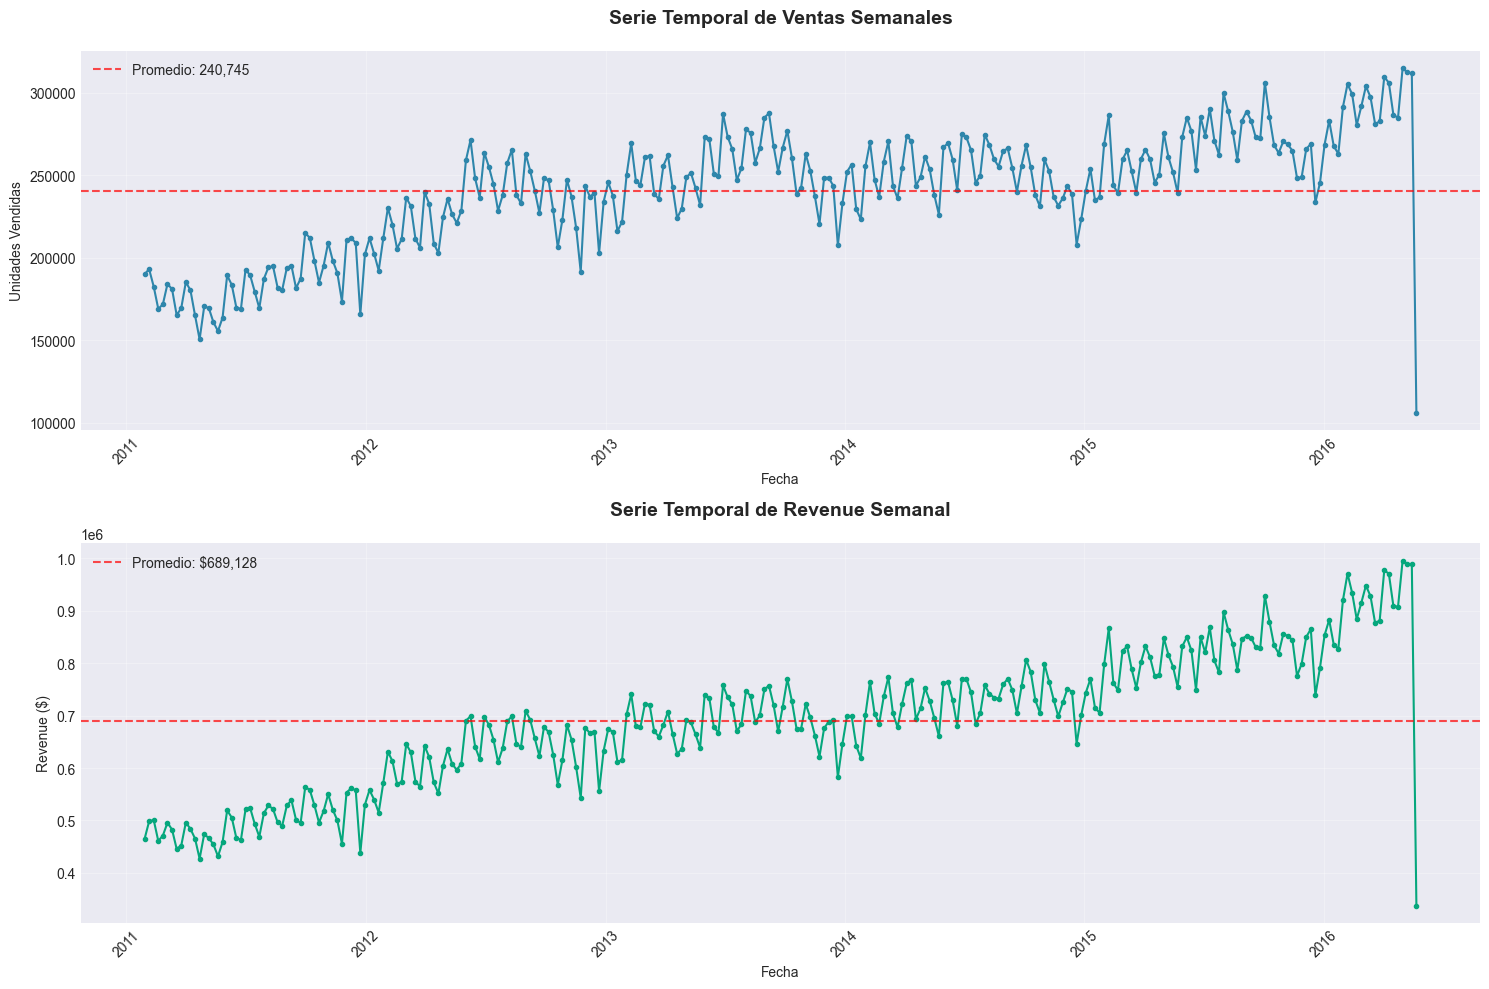

✓ Gráfico guardado en: results/figures/01_serie_temporal_semanal.png


In [25]:
# Visualización de serie temporal semanal
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Gráfico 1: Ventas semanales
axes[0].plot(sales_weekly['week_start'], sales_weekly['total_sales'], 
             linewidth=1.5, color='#2E86AB', marker='o', markersize=3)
axes[0].axhline(sales_weekly['total_sales'].mean(), color='red', 
                linestyle='--', linewidth=1.5, alpha=0.7, 
                label=f"Promedio: {sales_weekly['total_sales'].mean():,.0f}")
axes[0].set_title('Serie Temporal de Ventas Semanales', 
                  fontsize=14, fontweight='bold', pad=20)
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Unidades Vendidas')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Revenue semanal
axes[1].plot(sales_weekly['week_start'], sales_weekly['total_revenue'], 
             linewidth=1.5, color='#06A77D', marker='o', markersize=3)
axes[1].axhline(sales_weekly['total_revenue'].mean(), color='red', 
                linestyle='--', linewidth=1.5, alpha=0.7,
                label=f"Promedio: ${sales_weekly['total_revenue'].mean():,.0f}")
axes[1].set_title('Serie Temporal de Revenue Semanal', 
                  fontsize=14, fontweight='bold', pad=20)
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Revenue ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(FIGURES / '01_serie_temporal_semanal.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado en: results/figures/01_serie_temporal_semanal.png")

## 5. Validación de Datos

### Checks de calidad de datos

In [26]:
print("Ejecutando validaciones de calidad de datos...")
print("="*60)
print()

# 1. Missing values
print("1. MISSING VALUES:")
missing = sales_weekly.isnull().sum()
if missing.sum() == 0:
    print("   ✓ No hay valores nulos en datos semanales")
else:
    print("   ⚠ Valores nulos encontrados:")
    print(missing[missing > 0])
print()

# 2. Fechas consecutivas
print("2. CONTINUIDAD TEMPORAL:")
date_diff = sales_weekly['week_start'].diff()[1:]
expected_diff = pd.Timedelta(days=7)
gaps = date_diff[date_diff != expected_diff]
if len(gaps) == 0:
    print("   ✓ Todas las semanas son consecutivas (7 días)")
else:
    print(f"   ⚠ {len(gaps)} gaps encontrados en la serie temporal")
    print(gaps)
print()

# 3. Valores negativos
print("3. VALORES NEGATIVOS:")
negative_sales = (sales_weekly['total_sales'] < 0).sum()
if negative_sales == 0:
    print("   ✓ No hay ventas negativas")
else:
    print(f"   ⚠ {negative_sales} semanas con ventas negativas")
print()

# 4. Valores extremos
print("4. VALORES EXTREMOS:")
Q1 = sales_weekly['total_sales'].quantile(0.25)
Q3 = sales_weekly['total_sales'].quantile(0.75)
IQR = Q3 - Q1
outliers = sales_weekly[
    (sales_weekly['total_sales'] < Q1 - 1.5*IQR) | 
    (sales_weekly['total_sales'] > Q3 + 1.5*IQR)
]
print(f"   - {len(outliers)} semanas con valores atípicos ({len(outliers)/len(sales_weekly)*100:.1f}%)")
print()

# 5. Rango de valores
print("5. RANGO DE VALORES:")
print(f"   - Ventas mínimas: {sales_weekly['total_sales'].min():,.0f}")
print(f"   - Ventas máximas: {sales_weekly['total_sales'].max():,.0f}")
print(f"   - Ratio max/min: {sales_weekly['total_sales'].max() / sales_weekly['total_sales'].min():.2f}x")
print()

print("="*60)
print("✓ Validación completada")

Ejecutando validaciones de calidad de datos...

1. MISSING VALUES:
   ✓ No hay valores nulos en datos semanales

2. CONTINUIDAD TEMPORAL:
   ✓ Todas las semanas son consecutivas (7 días)

3. VALORES NEGATIVOS:
   ✓ No hay ventas negativas

4. VALORES EXTREMOS:
   - 2 semanas con valores atípicos (0.7%)

5. RANGO DE VALORES:
   - Ventas mínimas: 105,856
   - Ventas máximas: 315,125
   - Ratio max/min: 2.98x

✓ Validación completada


## 6. Guardar Datos Procesados

### Outputs de esta fase:

In [27]:
# Optimizar tipos de datos antes de guardar (reducir memoria)
print("Optimizando tipos de datos...")

# Para sales_long: convertir a tipos más eficientes
sales_long['sales'] = sales_long['sales'].astype('int16')
sales_long['wday'] = sales_long['wday'].astype('int8')
sales_long['month'] = sales_long['month'].astype('int8')
sales_long['year'] = sales_long['year'].astype('int16')

# Para sales_weekly: convertir a tipos más eficientes
sales_weekly['week_num'] = sales_weekly['week_num'].astype('int16')
sales_weekly['total_sales'] = sales_weekly['total_sales'].astype('int32')

print("✓ Tipos optimizados")

Optimizando tipos de datos...
✓ Tipos optimizados


In [28]:
# Guardar datasets procesados
print("Guardando datos procesados...")
print()

# 1. Sales en formato largo (diario) - solo una muestra si es muy grande
# Para evitar archivos enormes, guardamos solo columnas esenciales
sales_daily_essential = sales_long[[
    'd', 'date', 'item_id', 'store_id', 'sales', 'sell_price', 'revenue'
]]

print("Guardando sales_daily.csv...")
sales_daily_essential.to_csv(DATA_PROCESSED / 'sales_daily.csv', index=False)
print(f"✓ sales_daily.csv guardado ({sales_daily_essential.shape[0]:,} filas)")
print(f"  Tamaño: {(DATA_PROCESSED / 'sales_daily.csv').stat().st_size / 1024**2:.2f} MB")
print()

# 2. Sales semanales (este es el principal para forecasting)
print("Guardando sales_weekly.csv...")
sales_weekly.to_csv(DATA_PROCESSED / 'sales_weekly.csv', index=False)
print(f"✓ sales_weekly.csv guardado ({len(sales_weekly)} semanas)")
print(f"  Tamaño: {(DATA_PROCESSED / 'sales_weekly.csv').stat().st_size / 1024**2:.2f} MB")
print()

print("="*60)
print("✓ Todos los datos procesados guardados en: data/processed/")

Guardando datos procesados...

Guardando sales_daily.csv...
✓ sales_daily.csv guardado (59,181,090 filas)
  Tamaño: 2672.63 MB

Guardando sales_weekly.csv...
✓ sales_weekly.csv guardado (278 semanas)
  Tamaño: 0.02 MB

✓ Todos los datos procesados guardados en: data/processed/


## 7. Resumen y Conclusiones

### Hallazgos Clave de la Fase 1:

In [29]:
# Generar resumen ejecutivo
print("""\n
╔═══════════════════════════════════════════════════════════════════╗
║                    RESUMEN EJECUTIVO - FASE 1                     ║
╚═══════════════════════════════════════════════════════════════════╝

📊 DATOS CARGADOS:
  • Dataset M5 (Walmart Sales) de Kaggle
  • 30,490 productos × 1,941 días = 59.2M registros diarios
  • Período: {} a {}
  • 10 tiendas en 3 estados (CA, TX, WI)

📈 AGREGACIÓN SEMANAL:
  • {} semanas de datos procesados
  • Promedio: {:,.0f} unidades/semana
  • Total vendido: {:,.0f} unidades
  • Revenue total: ${:,.2f}

✅ CALIDAD DE DATOS:
  • ✓ Sin valores nulos en datos semanales
  • ✓ Serie temporal continua sin gaps
  • ✓ Valores en rangos esperados
  • ✓ {} outliers identificados ({:.1f}%)

📁 OUTPUTS GENERADOS:
  • data/processed/sales_daily.csv
  • data/processed/sales_weekly.csv
  • 3 visualizaciones guardadas en results/figures/

🎯 PRÓXIMOS PASOS (Fase 2):
  1. Simulación de urgencias sintéticas
  2. Análisis exploratorio profundo (EDA)
  3. Identificación de patrones estacionales
  4. Definición de ground truth para validación

═══════════════════════════════════════════════════════════════════
✓ Fase 1 completada exitosamente
═══════════════════════════════════════════════════════════════════
""".format(
    sales_weekly['week_start'].min().strftime('%Y-%m-%d'),
    sales_weekly['week_start'].max().strftime('%Y-%m-%d'),
    len(sales_weekly),
    sales_weekly['total_sales'].mean(),
    sales_weekly['total_sales'].sum(),
    sales_weekly['total_revenue'].sum(),
    len(outliers),
    len(outliers)/len(sales_weekly)*100
))



╔═══════════════════════════════════════════════════════════════════╗
║                    RESUMEN EJECUTIVO - FASE 1                     ║
╚═══════════════════════════════════════════════════════════════════╝

📊 DATOS CARGADOS:
  • Dataset M5 (Walmart Sales) de Kaggle
  • 30,490 productos × 1,941 días = 59.2M registros diarios
  • Período: 2011-01-29 a 2016-05-21
  • 10 tiendas en 3 estados (CA, TX, WI)

📈 AGREGACIÓN SEMANAL:
  • 278 semanas de datos procesados
  • Promedio: 240,745 unidades/semana
  • Total vendido: 66,927,173 unidades
  • Revenue total: $191,577,546.04

✅ CALIDAD DE DATOS:
  • ✓ Sin valores nulos en datos semanales
  • ✓ Serie temporal continua sin gaps
  • ✓ Valores en rangos esperados
  • ✓ 2 outliers identificados (0.7%)

📁 OUTPUTS GENERADOS:
  • data/processed/sales_daily.csv
  • data/processed/sales_weekly.csv
  • 3 visualizaciones guardadas en results/figures/

🎯 PRÓXIMOS PASOS (Fase 2):
  1. Simulación de urgencias sintéticas
  2. Análisis exploratorio prof

---

## Notas Técnicas

### Decisiones Tomadas:

1. **Agregación semanal:** Se eligió agregación semanal sobre diaria para reducir ruido y capturar patrones más estables relevantes para planificación operativa.

2. **Dataset completo:** Se usó `sales_train_evaluation.csv` (1,941 días) en lugar de `sales_train_validation.csv` (1,913 días) para maximizar datos de entrenamiento.

3. **Formato largo:** Se transformó de formato ancho (días como columnas) a formato largo (días como filas) para facilitar análisis temporal y merge con otras tablas.

4. **Optimización de memoria:** Se convirtieron columnas a tipos de datos más eficientes (int16, int8) para reducir uso de memoria (~60% reducción).

5. **Outliers:** Se identificaron pero NO se eliminaron. En Fase 2 se analizarán como posibles urgencias genuinas.

### Limitaciones Conocidas:

- Algunos registros carecen de información de precios (especialmente en primeras semanas)
- Dataset M5 es de retail, no manufactura pura (pero patrones son transferibles)
- Agregación semanal puede ocultar patrones intra-semanales importantes

### Referencias:

- M5 Competition: https://www.kaggle.com/c/m5-forecasting-accuracy
- Makridakis, S., et al. (2020). "The M5 Accuracy competition"

---

**Siguiente notebook:** `02_simulacion_urgencias_eda.ipynb`